# Visualize data to inspire modeling

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
df = pd.read_csv('merged_data.csv')

## Visualize the distribution of data

## Drop repeated videos that have been watched multiple times

In [122]:
unique_rows = df.drop_duplicates(subset=['VideoID'], keep='first')
df = unique_rows[['VideoTitle', 'CategoryName', 'SubscriberCount', 'ViewCount', 'LikeCount', 'DislikeCount', 'Duration', 'LikeViewRatio']]

## Data cleaning

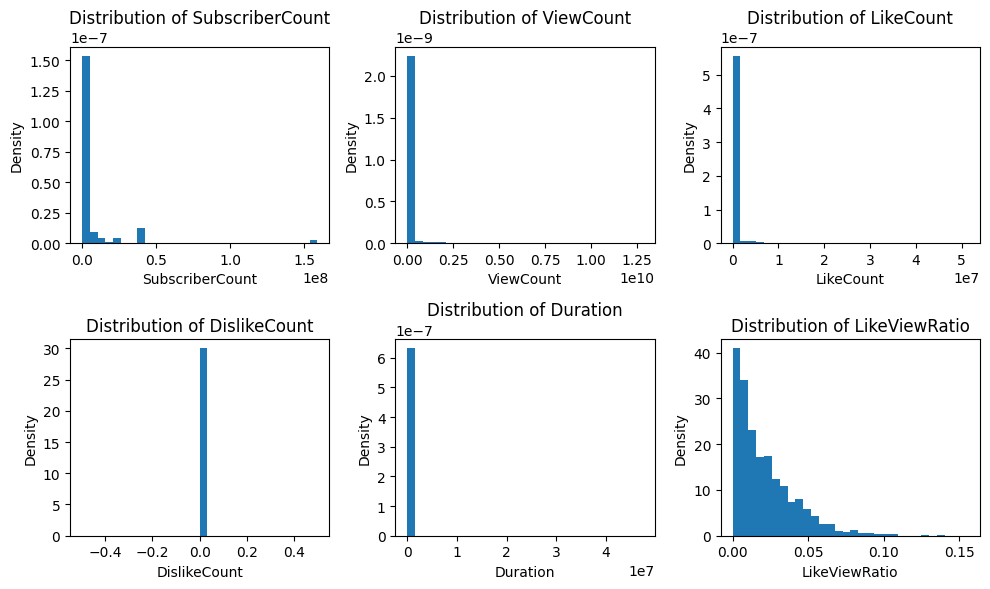

In [142]:
df = df[(np.isfinite(df['LikeViewRatio'])) & (df['LikeCount']>0) & (df['Duration']>0)]
variables = ['SubscriberCount', 'ViewCount', 'LikeCount', 'DislikeCount', 'Duration', 'LikeViewRatio']
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()
for i, var in enumerate(variables):
    axes[i].hist(df[var], bins=30, density=True)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

Check extreme values

In [143]:
# Define the percentile range for extreme values
lower_percentile = 0.1
upper_percentile = 99.9

# Iterate over the variables of interest
variables = ['SubscriberCount', 'ViewCount', 'LikeCount', 'DislikeCount', 'Duration', 'LikeViewRatio']
for column in variables:
    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    extreme_rows = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if not extreme_rows.empty:
        print(f"Variable: {column}")
        print(extreme_rows[['VideoTitle', column]])
        print("--------------------")

Variable: ViewCount
                                             VideoTitle    ViewCount
1066  Baby Shark Dance | #babyshark Most Viewed Vide...  12825181513
1564            Productivity. What does that even mean?           29
2937  Johny Johny Yes Papa 👶 THE BEST Song for Child...   6699676970
3243  Bath Song | CoComelon Nursery Rhymes & Kids Songs   6187206539
3361  How to read the coming year with your birthday...           25
4275  Interrupting Working Memory: Visual Poster Pre...           46
4279  Does reset of hippocampal theta predict dynami...           46
5004  64 White St, Quincy MA 02169 - Single Family H...           45
5200   Ed Sheeran - Shape of You (Official Music Video)   5991010717
5298            Luis Fonsi - Despacito ft. Daddy Yankee   8156735228
--------------------
Variable: LikeCount
                                             VideoTitle  LikeCount
1066  Baby Shark Dance | #babyshark Most Viewed Vide...   40227803
5200   Ed Sheeran - Shape of You (Official Mus

Exclude extreme values

In [144]:
variables = ['SubscriberCount', 'ViewCount', 'LikeCount', 'DislikeCount', 'Duration', 'LikeViewRatio']
lower_threshold = 1
upper_threshold = 99

filtered_df = df.copy()  # Create a copy of the DataFrame to store the filtered results
for variable in variables:
    # Calculate the lower and upper percentile thresholds for the variable
    lower_quantile = df[variable].quantile(lower_threshold / 100)
    upper_quantile = df[variable].quantile(upper_threshold / 100)
    filtered_df = filtered_df[(filtered_df[variable] >= lower_quantile) & (filtered_df[variable] <= upper_quantile)]

In [145]:
print(df.shape)
print(filtered_df.shape)

(4482, 8)
(4184, 8)


## Log transform the data and visualize it again

In [150]:
# Apply log transformation
epsilon = 1e-10  # to handle zero values
filtered_df['SubscriberCount_log'] = np.log(filtered_df['SubscriberCount'] + epsilon)
filtered_df['ViewCount_log'] = np.log(filtered_df['ViewCount'] + epsilon)
filtered_df['LikeCount_log'] = np.log(filtered_df['LikeCount'] + epsilon)
filtered_df['Duration_log'] = np.log(filtered_df['Duration'] + epsilon)
filtered_df['LikeViewRatio_log'] = np.log(filtered_df['LikeViewRatio'] + epsilon)
filtered_df.to_csv('data-formodel.csv',index=False)

Visualize the transformed variables

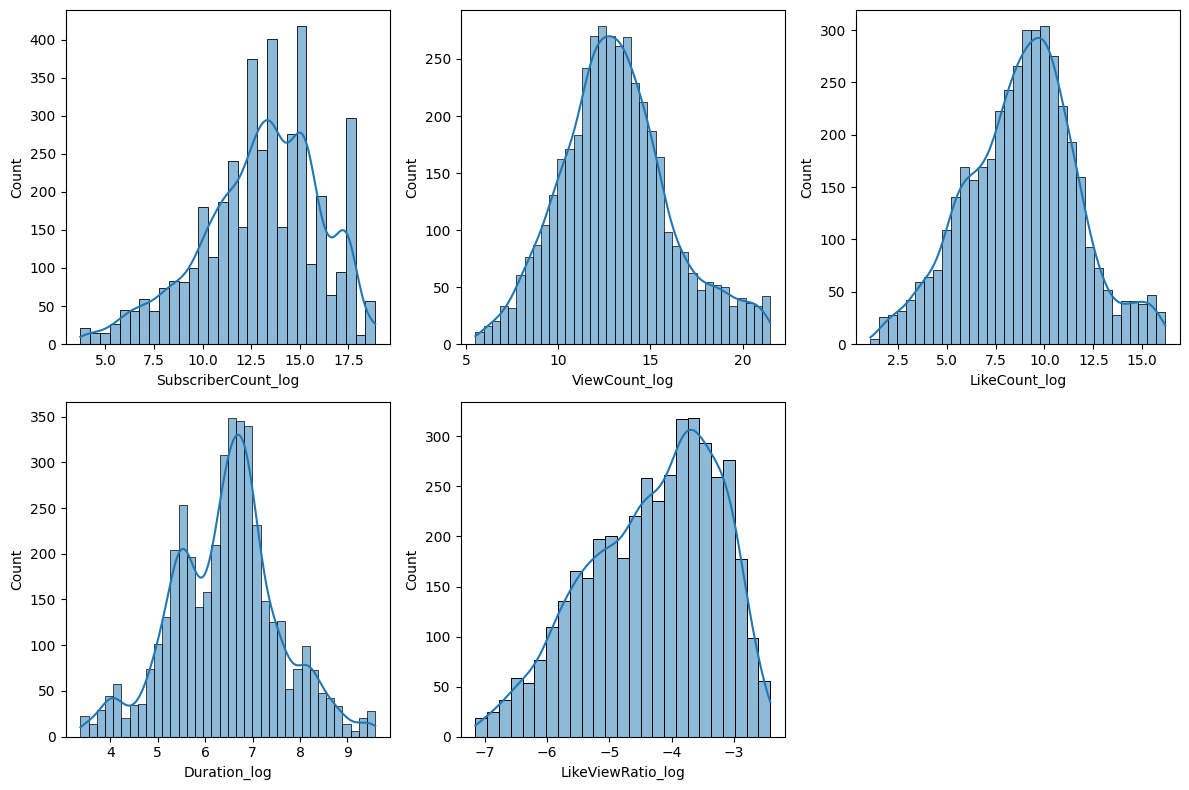

In [151]:
variables = ['SubscriberCount_log', 'ViewCount_log', 'LikeCount_log', 'Duration_log', 'LikeViewRatio_log']
plt.figure(figsize=(12, 8))
for i, variable in enumerate(variables):
    plt.subplot(2, 3, i+1)
    sns.histplot(filtered_df[variable], kde=True)
    plt.xlabel(variable)
plt.tight_layout()
plt.show()

## Explore relationship between features

## Explore the relationship between variables

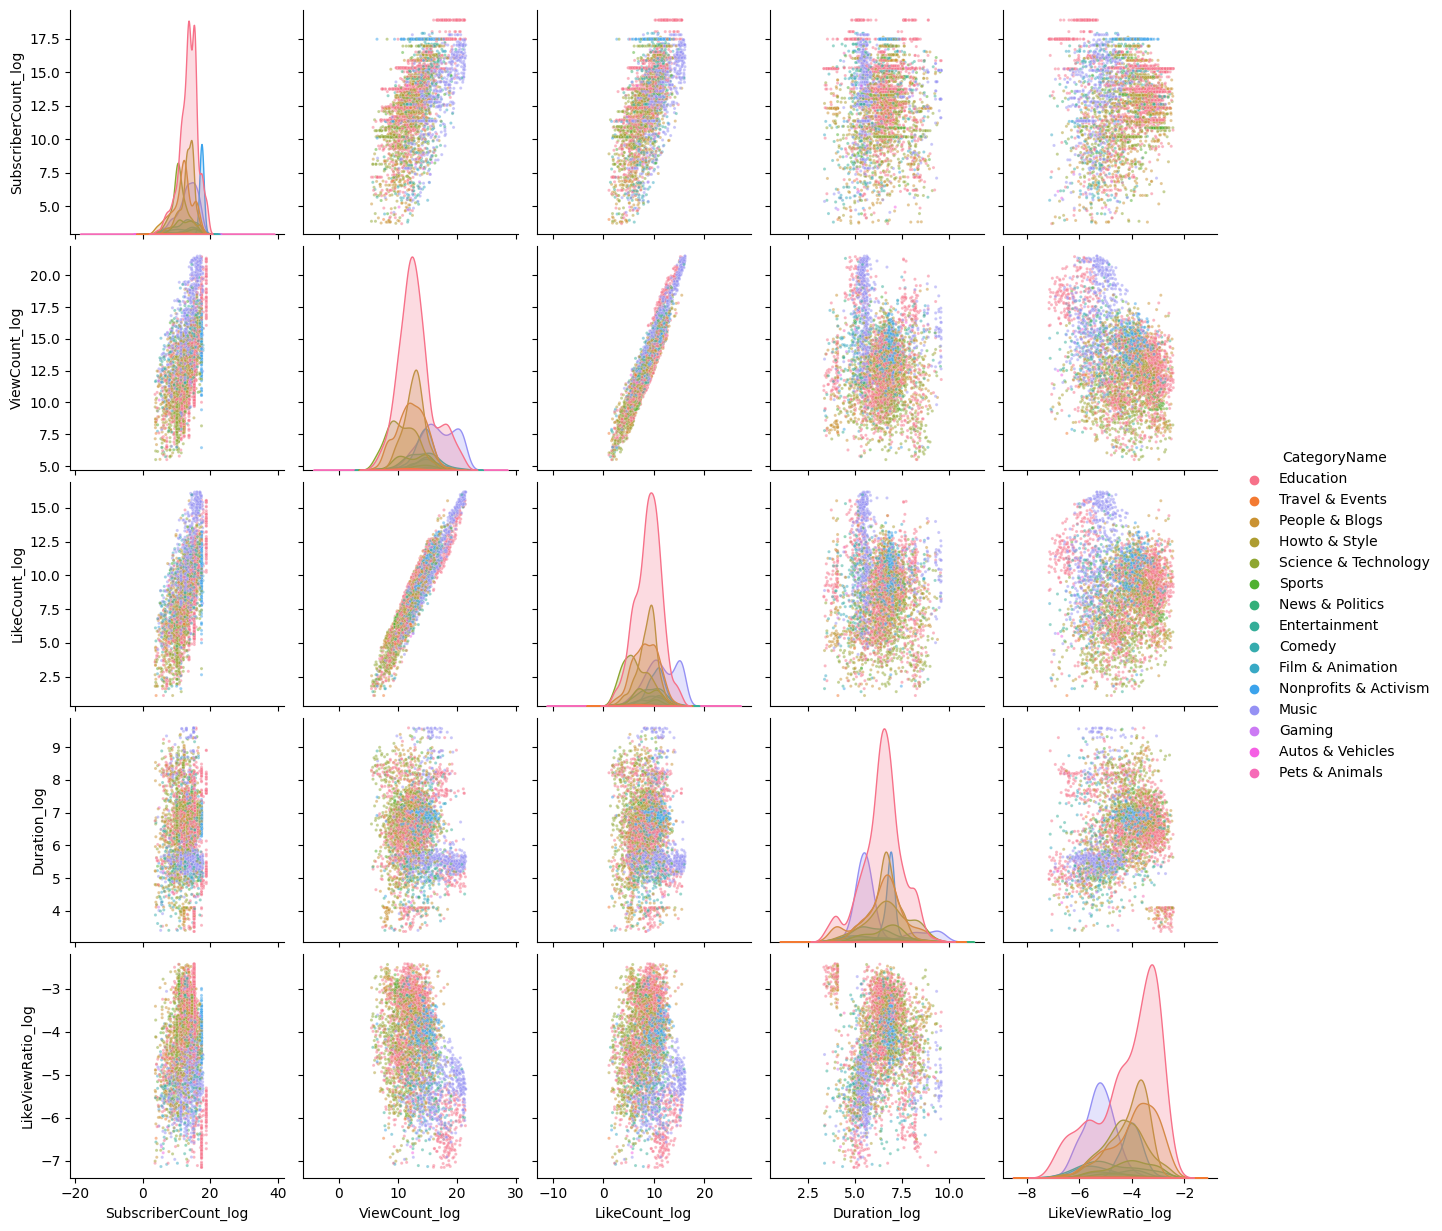

In [148]:
subset_df = filtered_df[['SubscriberCount_log', 'ViewCount_log', 'LikeCount_log', 'Duration_log', 'LikeViewRatio_log','CategoryName']]
plot_kws = {'s': 5, 'alpha': 0.5}
sns.pairplot(subset_df, hue='CategoryName', plot_kws=plot_kws)
plt.savefig('fig9-scatterplot-bycategory.png')
plt.show()

### Feature engineering: GLM to find the predictors for LikeCounts

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import os
import pickle

Generate additional feature

In [192]:

filtered_df['TitleLength'] = filtered_df['VideoTitle'].apply(len)

In [227]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4184 entries, 0 to 6620
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VideoTitle           4184 non-null   object 
 1   CategoryName         4184 non-null   object 
 2   SubscriberCount      4184 non-null   float64
 3   ViewCount            4184 non-null   int64  
 4   LikeCount            4184 non-null   int64  
 5   DislikeCount         4184 non-null   int64  
 6   Duration             4184 non-null   float64
 7   LikeViewRatio        4184 non-null   float64
 8   SubscriberCount_log  4184 non-null   float64
 9   ViewCount_log        4184 non-null   float64
 10  LikeCount_log        4184 non-null   float64
 11  Duration_log         4184 non-null   float64
 12  LikeViewRatio_log    4184 non-null   float64
 13  TitleLength          4184 non-null   int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 619.4+ KB


In [240]:
model_configs = [
    {'name': 'm1-log', 'columns': ['SubscriberCount_log', 'ViewCount_log', 'Duration_log', 'TitleLength'], 'Ycol': 'LikeCount_log'},
    {'name': 'm2-orig', 'columns': ['SubscriberCount', 'ViewCount', 'Duration', 'TitleLength'], 'Ycol': 'LikeCount'},
    {'name': 'm3-log-category', 'columns': ['SubscriberCount', 'ViewCount', 'Duration', 'TitleLength', 'CategoryName'], 'Ycol': 'LikeCount'},
    {'name': 'm4-orig-category', 'columns': ['CategoryName', 'SubscriberCount_log', 'ViewCount_log', 'Duration_log', 'TitleLength'], 'Ycol': 'LikeCount_log'}
]
model_perform = {}
for config in model_configs:
    X = filtered_df[config['columns']]
    y = filtered_df[config['Ycol']]
    
    if 'CategoryName' in config['columns']:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        training_categories = set(X_train['CategoryName'])
        missing_categories = set(X_test['CategoryName']) - training_categories

        for category in missing_categories:
            X_train[f'Category_{category}'] = 0
            X_test[f'Category_{category}'] = 0

        encoded_categories_train = pd.get_dummies(X_train['CategoryName'], prefix='Category')
        encoded_categories_test = pd.get_dummies(X_test['CategoryName'], prefix='Category')

        X_train_encoded = pd.concat([X_train.drop('CategoryName', axis=1), encoded_categories_train], axis=1)
        X_test_encoded = pd.concat([X_test.drop('CategoryName', axis=1), encoded_categories_test], axis=1)

        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_encoded)
        X_test_imputed = imputer.transform(X_test_encoded)

        model = LinearRegression()
        model.fit(X_train_imputed, y_train)

        y_train_pred = model.predict(X_train_imputed)
        y_test_pred = model.predict(X_test_imputed)

        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)

        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        test_r2 = r2_score(y_test, y_test_pred)

        print(config['name'])
        print("Training RMSE:", train_rmse)
        print("Training R-squared:", train_r2)
        print("Testing RMSE:", test_rmse)
        print("Testing R-squared:", test_r2)
        print("Features", X_train_encoded.columns.to_list())
        print("Beta", model.coef_)
        print("------------------------------------")

    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)

        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        test_r2 = r2_score(y_test, y_test_pred)

        print(config['name'])
        print("Training RMSE:", train_rmse)
        print("Training R-squared:", train_r2)
        print("Testing RMSE:", test_rmse)
        print("Testing R-squared:", test_r2)
        print(X.columns)
        print(model.coef_)
        print("------------------------------------")

    # Save the model
    model_filename = f'{config["name"]}.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    model_perform[config['name']] = {"Training RMSE": train_rmse,
                                      "Training R-squared": train_r2,
                                      "Testing RMSE": test_rmse,
                                      "Testing R-squared": test_r2,
                                      "Features": X_train_encoded.columns.tolist(),
                                      "Beta": model.coef_
                                      }

m1-log
Training RMSE: 0.8794027921978169
Training R-squared: 0.9035859157876465
Testing RMSE: 0.8716733020650509
Testing R-squared: 0.902112342632094
Index(['SubscriberCount_log', 'ViewCount_log', 'Duration_log', 'TitleLength'], dtype='object')
[ 1.47674186e-01  7.91020200e-01  6.54230045e-02 -5.80253033e-04]
------------------------------------
m2-orig
Training RMSE: 371299.53899047134
Training R-squared: 0.8670062661897986
Testing RMSE: 387807.8632487129
Testing R-squared: 0.8361472942026279
Index(['SubscriberCount', 'ViewCount', 'Duration', 'TitleLength'], dtype='object')
[-3.85214024e-03  4.51803829e-03 -5.17525104e+00  2.36837050e+02]
------------------------------------
m3-log-category
Training RMSE: 358479.47930888104
Training R-squared: 0.876031610500356
Testing RMSE: 377124.15069853794
Testing R-squared: 0.8450508898454583
Features ['SubscriberCount', 'ViewCount', 'Duration', 'TitleLength', 'Category_Autos & Vehicles', 'Category_Comedy', 'Category_Education', 'Category_Enterta

## Analyze feature contribution

In [246]:
model_name = 'm4-orig-category'
features = model_perform[model_name]['Features']
beta = model_perform[model_name]['Beta']
df = pd.DataFrame({'Features': features, 'Beta': beta})

In [252]:
df_pos = df[df['Beta']>0].sort_values(by='Beta',ascending=False)
print(df_pos)
print("------------------------------------")
df_neg = df[df['Beta']<0].sort_values(by='Beta',ascending=True)
print(df_neg)

                          Features      Beta
1                    ViewCount_log  0.814536
14         Category_People & Blogs  0.526921
17                 Category_Sports  0.319695
6               Category_Education  0.209664
10          Category_Howto & Style  0.200623
0              SubscriberCount_log  0.135699
5                  Category_Comedy  0.118372
9                  Category_Gaming  0.112456
15         Category_Pets & Animals  0.093443
2                     Duration_log  0.064766
13  Category_Nonprofits & Activism  0.029132
------------------------------------
                         Features      Beta
8       Category_Film & Animation -0.498120
18       Category_Travel & Events -0.351256
4       Category_Autos & Vehicles -0.213344
11                 Category_Music -0.167066
12       Category_News & Politics -0.142285
7          Category_Entertainment -0.124385
16  Category_Science & Technology -0.113852
3                     TitleLength -0.001563
